In [33]:
import librosa
import numpy as np
import os
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy import signal

sr = 44100

In [34]:
def load(filename, sr=44100):
    path = os.path.join("..", "exports", filename)
    y, _ = librosa.load(path, sr=sr)
    return y
    
def mel_spectrogram(y, sr=44100, n_fft=2048, hop_length=512, n_mels=128):
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db

def mse_similarity(S1, S2):
    return np.mean((mel_spectrogram(S1) - mel_spectrogram(S2))**2)


def mfcc_similarity(S1, S2):
    return np.mean((mfcc(S1) - mfcc(S2))**2)

def show_spectrogram(S_db, sr=44100):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sr, hop_length=512,
                             x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel Spectrogram")
    plt.tight_layout()
    plt.show()

def mfcc(audio):
    return librosa.feature.mfcc(y=audio, sr=44100, n_mfcc=13)

def show_mfcc(_mfcc):
    # Visualizar
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(_mfcc, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.show()

BASE_FREQ = 440
notes = np.array([BASE_FREQ/16, BASE_FREQ/4, BASE_FREQ, BASE_FREQ*4, BASE_FREQ*16])
cmap = LinearSegmentedColormap.from_list("blue_red", ["#FFFFFF", "#e24a4a"])

In [35]:
# misma frecuencia diferentes formas de onda. (440)
# tabla de similitud entre ondas

# azul parecido y rojo no parecida


# Tomar 5 notas en un piano. 5 notas . La 4 y dos en cada extremo. Lo mismo de arriba (4x4 para diferente frecuencia) (Ruido y sin ruido)
# Usar la misma escala de calor.

# Combinaciones (Sinusoidales). f1 con f2, f2 con f3, etcc..... Compararlas contra las otras 10 combinaciones. Tabla de 10*10. El mismo volumen a ambas.
# A0 A2 A4 A6 A8
# Escala de calor

# repetir todo eso con ruido y sin ruido. Medidas de ruido. PCNR

# Usar la misma escala de color

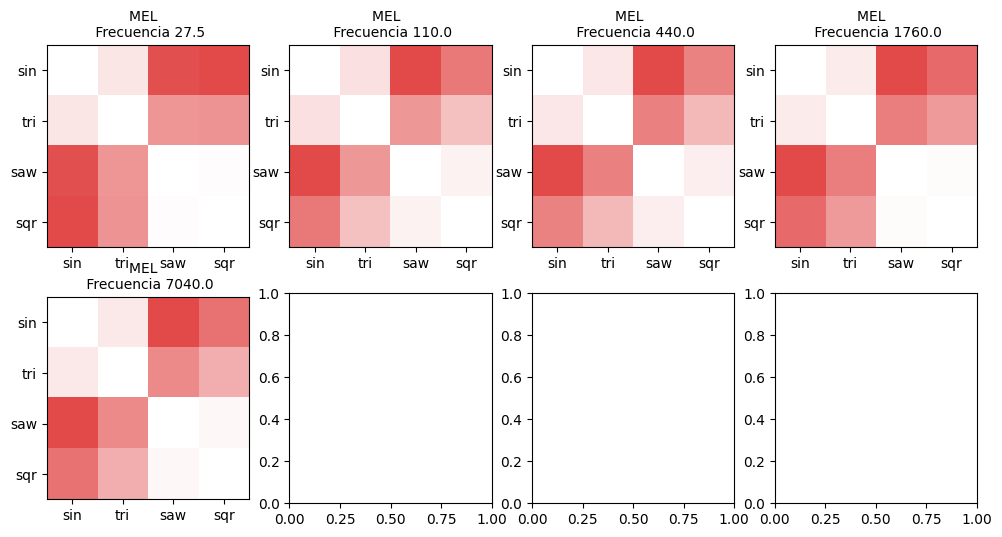

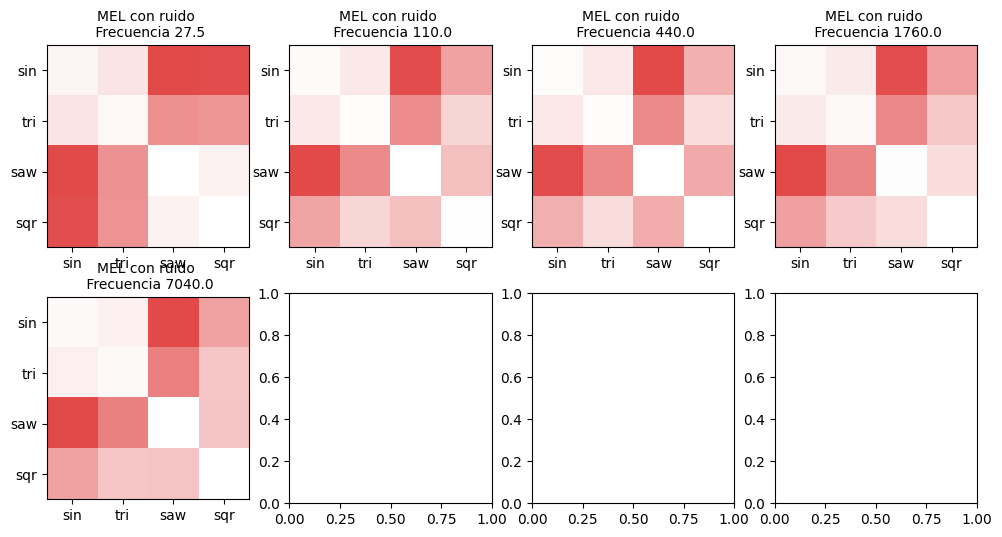

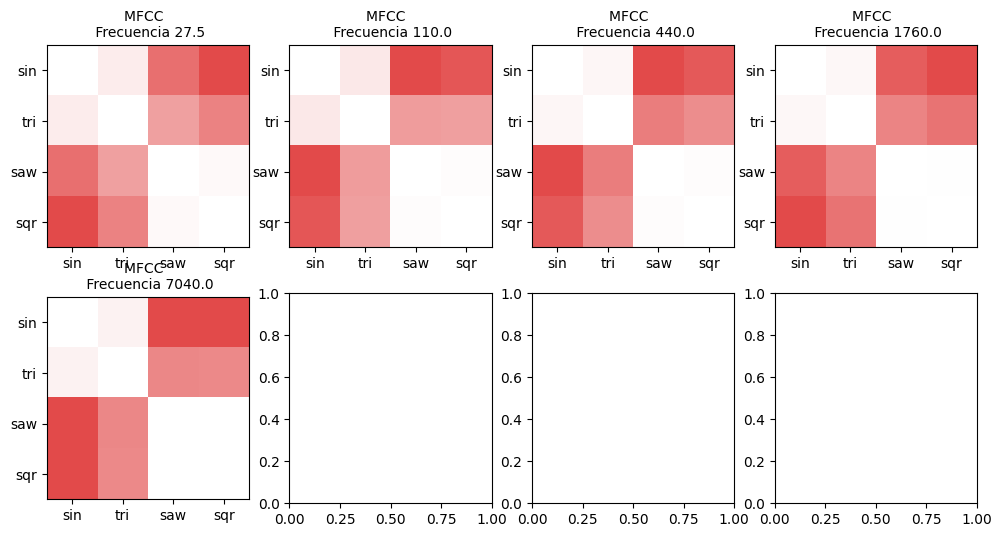

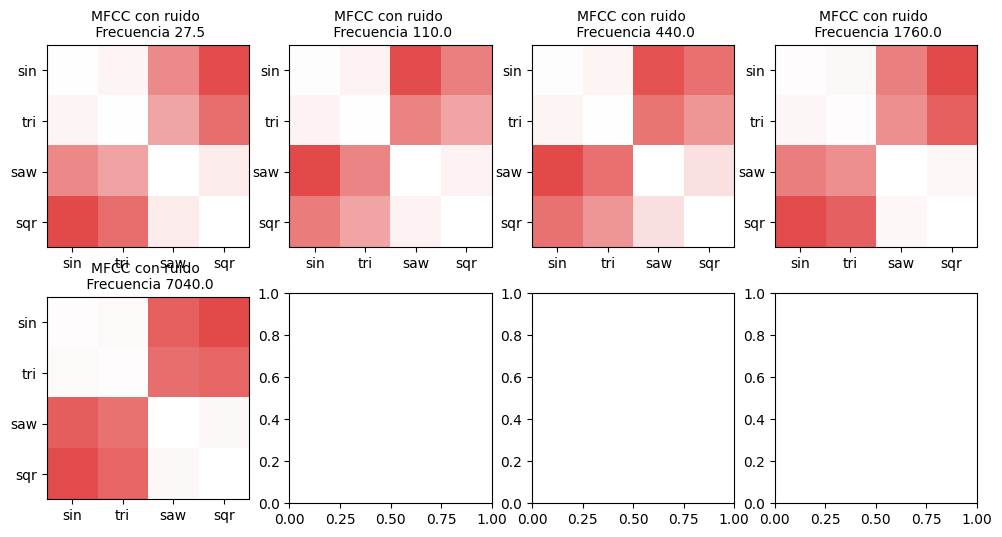

In [36]:
import sys
import os

# Obtener la ruta del directorio del notebook
ruta_actual = os.getcwd()

# Agregar el directorio superior
ruta_superior = os.path.abspath(os.path.join(ruta_actual, '..'))
sys.path.append(ruta_superior)

wave_names = ['sin', 'tri', 'saw', 'sqr']

def get_wave(forma, fase):
    if forma == 0:  # Seno
        return np.sin(fase)
    elif forma == 1:  # Triangular
        return signal.sawtooth(fase, width=0.5)
    elif forma == 2:  # Sawtooth
        return signal.sawtooth(fase)
    elif forma == 3:  # Cuadrada
        return signal.square(fase)
    else:
        raise ValueError("Forma no válida. Debe ser 0, 1, 2 o 3.")

t = np.linspace(0, 1, 44100)

def get_phase(freq):
    phi = np.pi/4*0
    return 2 * np.pi * freq * t + phi

def get_noise():
    return 0.05*np.random.normal(0, 1, 44100)

def wave_comparision(with_noise=False, with_mfcc=False):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    
    axes_flat = axes.flatten()

    N = 4
    position=0
    for freq in notes:
        ax = axes_flat[position]
        mse_similarities = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                w1 = get_wave(i,get_phase(freq))
                w2 = get_wave(j,get_phase(freq))

                if with_noise:
                    w1 += get_noise()
                    w2 += get_noise()

                if with_mfcc:
                    mse_similarities[i,j] = mfcc_similarity(w1, w2)
                else:
                    mse_similarities[i,j] = mse_similarity(w1, w2)

        ax.imshow(mse_similarities, cmap=cmap)
        ax.set_title(f"{'MFCC' if with_mfcc else 'MEL'} {'con ruido' if with_noise else ''} \n Frecuencia {freq}", fontsize=10)
        ax.set_xticks(ticks=np.arange(4), labels=wave_names)
        ax.set_yticks(ticks=np.arange(4), labels=wave_names)
        position+=1

wave_comparision(with_noise=False, with_mfcc=False)
wave_comparision(with_noise=True, with_mfcc=False)
wave_comparision(with_noise=False, with_mfcc=True)
wave_comparision(with_noise=True, with_mfcc=True)

# plt.plot(create_morphed_wave(3,get_phase(440))[:400])
# plt.show()

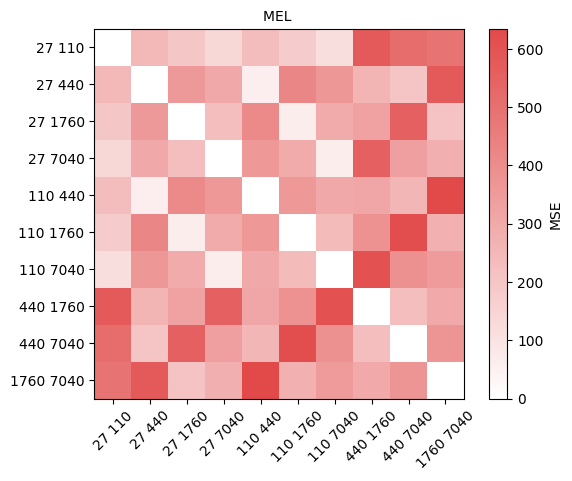

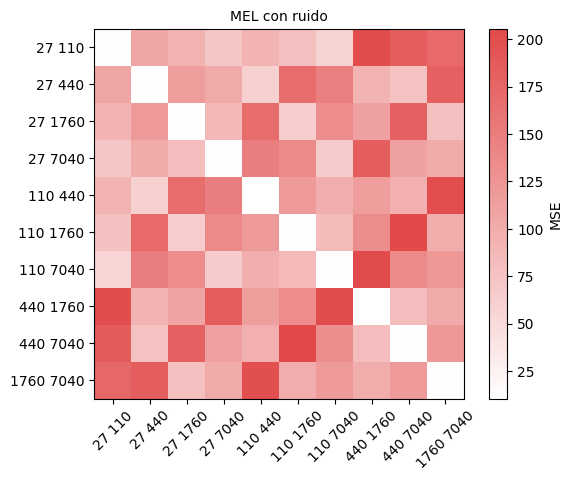

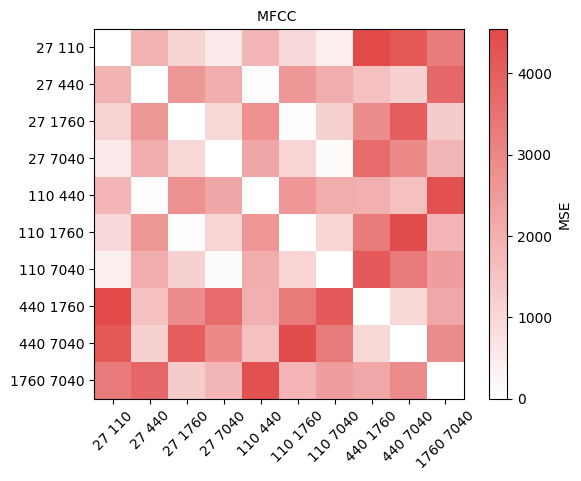

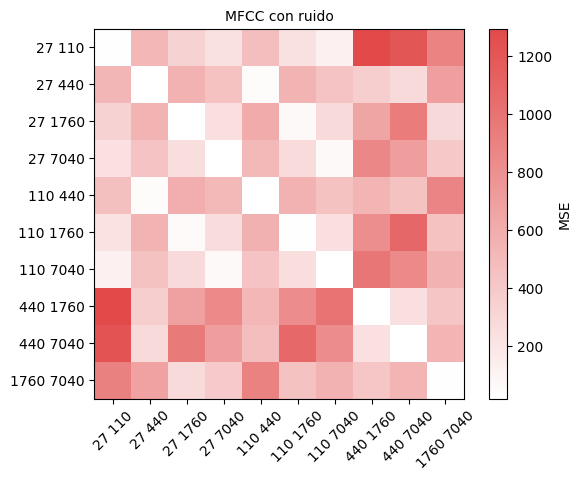

In [37]:
import itertools

parsed_label = lambda x: f"{int(x[0])} {int(x[1])}"

def freq_comparision(with_noise=False, with_mfcc=False):
    N = 10
    mse_similarities = np.zeros((N,N))

    combinations = list(itertools.combinations(notes, 2))

    for i in range(N):
        for j in range(N):
            f1, f2 = combinations[i]
            f3, f4 = combinations[j]

            iwave = get_wave(0, get_phase(f1)) + get_wave(0, get_phase(f2))
            jwave = get_wave(0, get_phase(f3)) + get_wave(0, get_phase(f4))

            if with_noise:
                iwave += get_noise()
                jwave += get_noise()

            if with_mfcc:
                mse_similarities[i,j] = mfcc_similarity(iwave, jwave)
            else:
                mse_similarities[i,j] = mse_similarity(iwave, jwave)

    # print(mse_similarities)
    plt.imshow(mse_similarities, cmap=cmap)
    plt.colorbar(label='MSE')
    plt.title(f"{'MFCC' if with_mfcc else 'MEL'} {'con ruido' if with_noise else ''}", fontsize=10)
    plt.xticks(ticks=np.arange(len(combinations)), labels=map(parsed_label,combinations), rotation=45)  # rotar para que no se solapen
    plt.yticks(ticks=np.arange(len(combinations)), labels=map(parsed_label,combinations))
    plt.pause(0.001)

freq_comparision(with_noise=False, with_mfcc=False)
freq_comparision(with_noise=True, with_mfcc=False)
freq_comparision(with_noise=False, with_mfcc=True)
freq_comparision(with_noise=True, with_mfcc=True)